## Caption Similarity

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import string
import operator

import matplotlib as mpl

In [2]:
import caption_contest_data as ccd

### The sentence encoder
We're using [this](https://tfhub.dev/google/universal-sentence-encoder/2) model for sentence embedding. If you don't have it downloaded to the local directory below, replace the below cell with
```python
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
```
to have the model downloaded.

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [4]:
import os
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "1"
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

This cell cached the downloaded files (though I don't know where on macOS).

In [5]:
# embed = hub.Module("./universal-sentence-encoder")

### The caption data

We'll just work with the first 500 captions from the csv.

10025


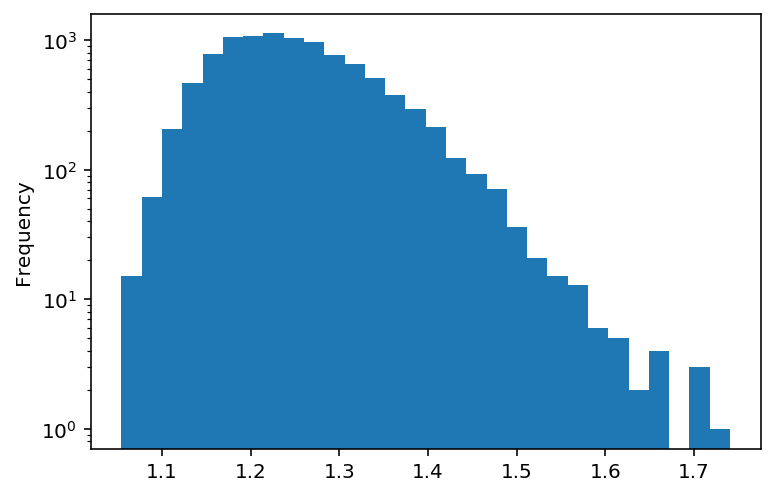

In [6]:
df = ccd.summary(652)
# df = df.sample(frac=1).reset_index(drop=True) # shuffle the data
print(len(df))
df.score.plot.hist(logy=True, bins=30)

In [7]:
# df = df[df.score > 1.5]
# just keep the first 500
df = df.head(500)
df.score.min()

1.4074074074074074

In [8]:
len(df)

500

In [9]:
means = df['score'].values
captions = df['caption'].values
distances = np.abs(means - means[:, None])

# We want to remove punctation since the model views "foo...bar" as one word
punctuation = string.punctuation.replace("'", "")  # but don't want to remove stuff like "We'll"
translator = str.maketrans(punctuation, ' ' * len(punctuation))
remove_punctuation = np.vectorize(lambda s: s.translate(translator))

captions = remove_punctuation(captions)

In [10]:
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_caption_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    embeddings = session.run(similarity_caption_encodings, feed_dict={similarity_input_placeholder: captions})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [11]:
corr = np.clip(np.inner(embeddings, embeddings), 0, 1)

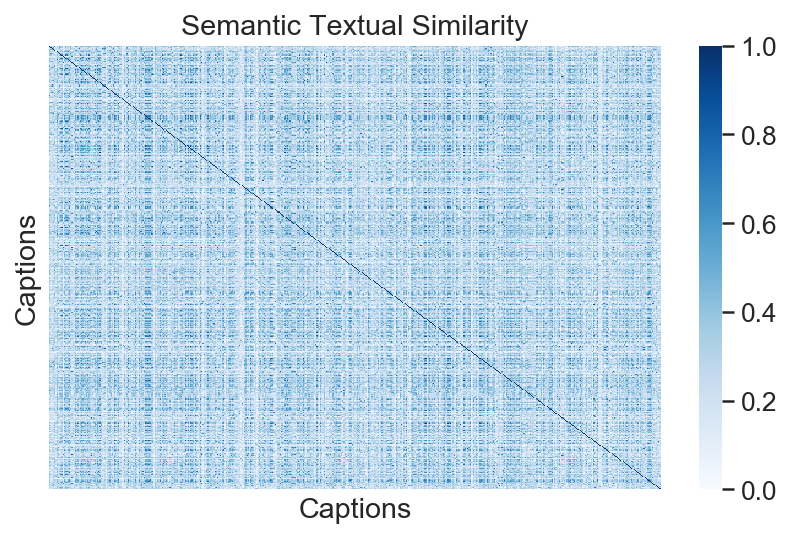

In [12]:
sns.set(font_scale=1.2)
ax = sns.heatmap(
    corr,
    xticklabels=[],
    yticklabels=[],
    vmin=0,
    vmax=1,
    cmap="Blues")
ax.set_title("Semantic Textual Similarity")
ax.set_xlabel("Captions")
ax.set_ylabel("Captions")
plt.tight_layout()
# plt.savefig("caption_similarity_heatmap.pdf", bbox_inches = "tight")
plt.show()

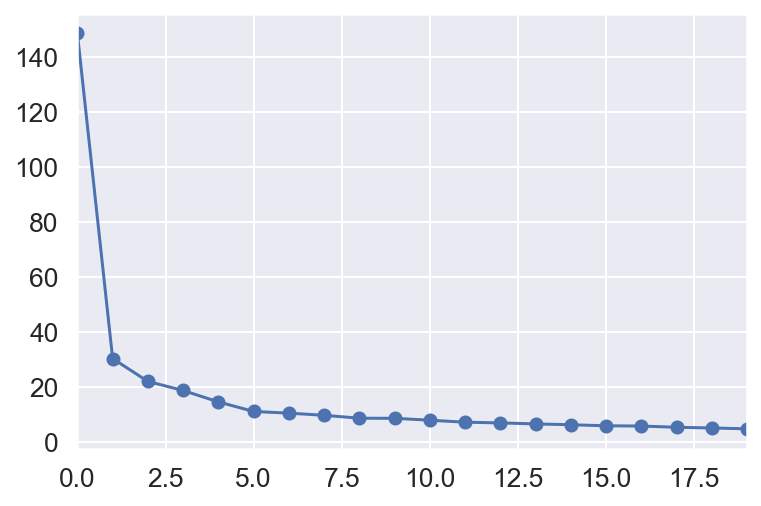

In [13]:
import numpy.linalg as LA
s = LA.svd(corr, full_matrices=False, compute_uv=False)
pd.Series(s[:20]).plot(style="o-", logy=False, logx=False)

/Users/scott/anaconda3/envs/ccd-api3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


(500, 500)
(500, 500)


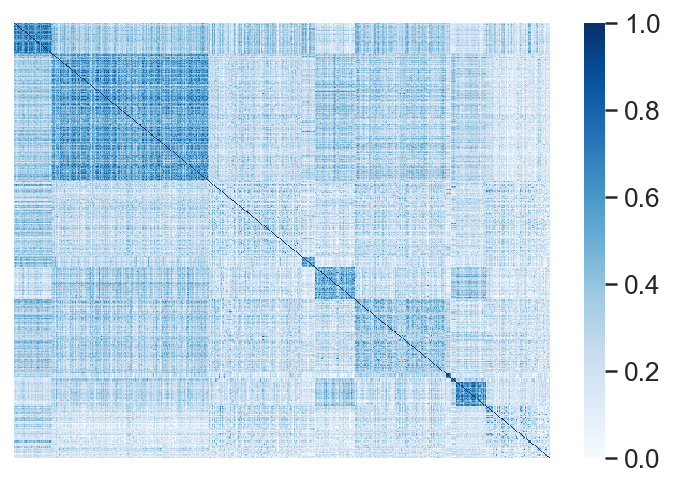

In [15]:
from sklearn.cluster import SpectralClustering, DBSCAN, MeanShift, AffinityPropagation
est = SpectralClustering(n_clusters=10)
# est = DBSCAN()
# est = MeanShift(bandwidth=1e-6)
# est = AffinityPropagation(damping=1 - 1e-2, convergence_iter=100, max_iter=1000)
est.fit(corr)
groups = est.labels_

idx = np.argsort(groups)

# rearrange rows
show = corr[idx, :]
# rearrange cols
print(show.shape)
show = show[:, idx]
print(show.shape)
ax = sns.heatmap(
    show,
    xticklabels=[],
    yticklabels=[],
    vmin=0,
    vmax=1,
    cmap="Blues"
)

(500, 500)
(500, 500)


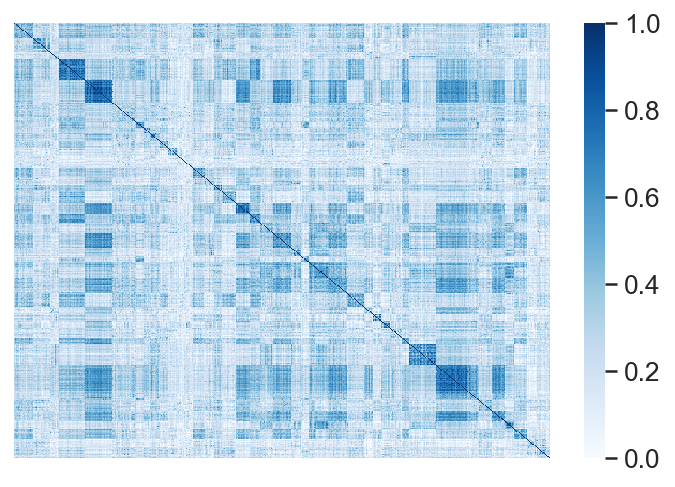

In [16]:
from sklearn.cluster import SpectralClustering, DBSCAN, MeanShift, AffinityPropagation
# est = SpectralClustering(n_clusters=10)
# est = DBSCAN()
# est = MeanShift(bandwidth=1e-6)
est = AffinityPropagation(damping=0.6, convergence_iter=100, max_iter=1000)
est.fit(corr)
groups = est.labels_

idx = np.argsort(groups)

# rearrange rows
show = corr[idx, :]
# rearrange cols
print(show.shape)
show = show[:, idx]
print(show.shape)
ax = sns.heatmap(
    show,
    xticklabels=[],
    yticklabels=[],
    vmin=0,
    vmax=1,
    cmap="Blues"
)

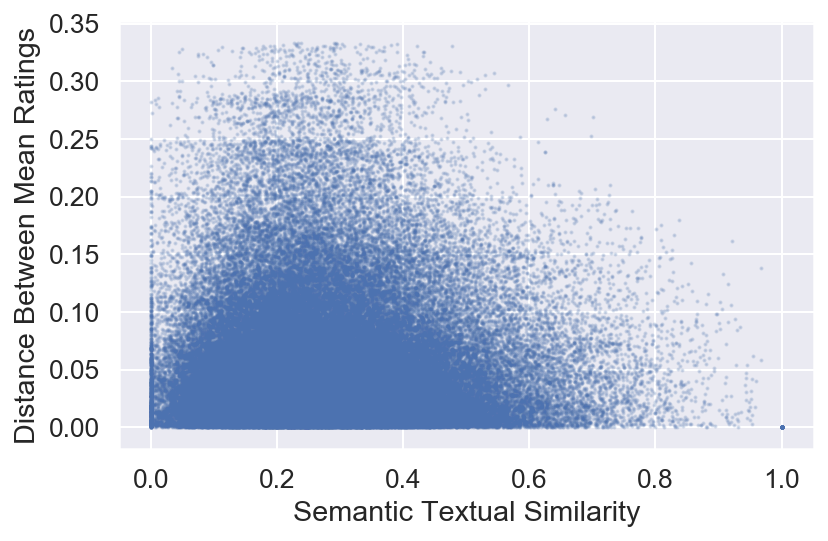

In [17]:
plt.scatter(corr.flatten(), distances.flatten(), s=1, alpha=0.1)
plt.xlabel("Semantic Textual Similarity")
plt.ylabel("Distance Between Mean Ratings")
plt.tight_layout()
# plt.savefig("caption_similarity_against_mean_distance.pdf", bbox_inches = "tight")
plt.show()

In [18]:
binned = pd.DataFrame({'sts': corr.flatten(),'dist': distances.flatten()})
binned = binned.groupby(pd.cut(binned.sts, bins=np.linspace(0, 1, 21))).dist.mean()

The plot below shows the data binned to the respective bins and the average of all values that land in the bin are the heights of the bar.

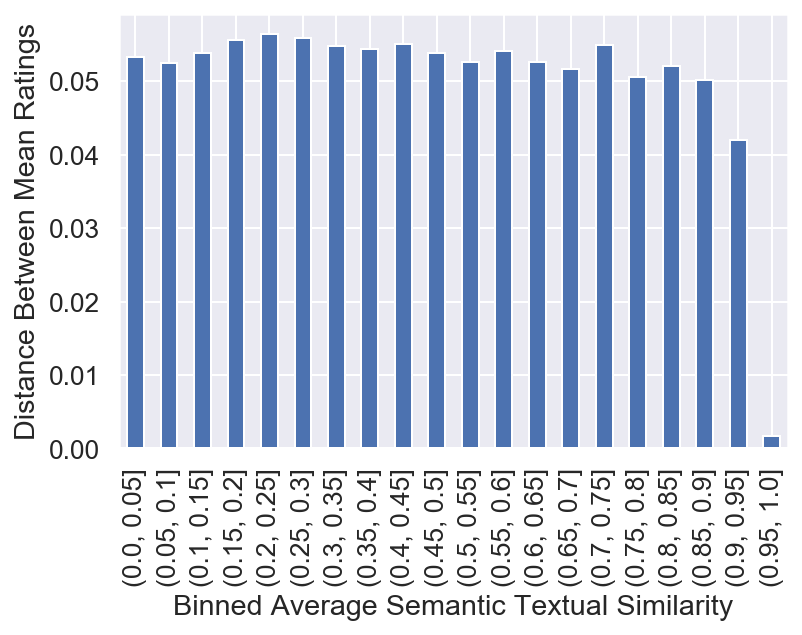

In [19]:
binned.plot.bar(color="b")
plt.xlabel("Binned Average Semantic Textual Similarity")
plt.ylabel("Distance Between Mean Ratings")
plt.savefig("caption_similarity_against_mean_distance_binned_20.pdf", bbox_inches = "tight")
plt.show()

In [20]:
df.index = df["rank"]
df.sample(20)[["caption"]]

,caption
rank,
216,"I've heard of mirages,but this takes the cake."
487,Still don't believe in Global Warming? That's ...
287,But can we really trust our eyes after the mer...
141,"Yeah,but we have to wait an hour to swim back."
72,Let's swim to the Sandwich Islands first.
73,"You know, if it weren’t for autocorrect, we wo..."
257,"Tempting, but we should probably hit the sandw..."
3,I do not see a lifesaver.
448,My palm tree doesn't spark joy anymore.


In [21]:
df["rank"].min()

1

In [22]:
for rank in [1, 3, 11, 13]:#, 21, 159, 158]:
    caption = df.loc[rank]["caption"]
    corrs = pd.Series({k + 1: c for k, c in enumerate(corr[rank - 1, :]) if k + 1 != rank})
    similar_ranks = corrs.nlargest(n=5).index
    i = similar_ranks.isnull()
    similar_ranks = similar_ranks[~i]
    show = df.loc[similar_ranks]["caption"]
    show = show.dropna()
    similar_captions = list(show)
    
    print("Caption:\n    ", caption)
    print("Similar captions:\n    -", "\n    - ".join(similar_captions))
    print("")

Caption:
     I wish we'd noticed that before eating Bob.
Similar captions:
    - I wish we’d seen that before we ate Dave.
    - Maybe we should have waited before eating Phillip.
    - Oh, you see that too? We probably should've talked about that before we ate Steve.
    - I swear! If you say that's the way the cookie crumbles ONE more time...
    - I guess we didn’t have to eat Danny. Or our raft.

Caption:
     I do not see a lifesaver.
Similar captions:
    - All that, and not a life saver to be seen  !
    - If only we had a Life Saver.
    - All that candy, and not one lifesaver.

Caption:
     Looks desserted to me.
Similar captions:
    - It certainly looks desserted.
    - 'Looks desserted.'
    - It looks pretty desserted.
    - Looks completely desserted.

Caption:
     Is it just me or are the sharks getting smarter?
Similar captions:
    - The sharks have sure upped their game.
    - The sharks have really upped their game.
    - These sharks are really bringing their A g

/Users/scott/anaconda3/envs/ccd-api3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  import sys
